# Домашнее задание №6.
Основы машинного обучения. Г.Господинов  
Группа ML-11. __Студент - Усцов Артем Алексеевич__

In [1]:
# Для функционирования watermark - раскомментируйте строку ниже, либо установите библиотеку в консоли вручную
# !pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,matplotlib,pandas,sklearn,seaborn,tqdm -g

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.28.0

numpy     : 1.20.1
scipy     : 1.6.2
matplotlib: 3.4.3
pandas    : 1.2.2
sklearn   : 0.0
seaborn   : 0.11.2
tqdm      : 4.62.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-88-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: af14cdf0fd62ff0b2f07b18b24a2d0c0619a7920



In [3]:
!lscpu

Архитектура:                     x86_64
CPU op-mode(s):                  32-bit, 64-bit
Порядок байт:                    Little Endian
Address sizes:                   39 bits physical, 48 bits virtual
CPU(s):                          8
On-line CPU(s) list:             0-7
Потоков на ядро:                 2
Ядер на сокет:                   4
Сокетов:                         1
NUMA node(s):                    1
ID прроизводителя:               GenuineIntel
Семейство ЦПУ:                   6
Модель:                          142
Имя модели:                      Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz
Степпинг:                        10
CPU МГц:                         3083.203
CPU max MHz:                     3400,0000
CPU min MHz:                     400,0000
BogoMIPS:                        3600.00
Виртуализация:                   VT-x
L1d cache:                       128 KiB
L1i cache:                       128 KiB
L2 cache:                        1 MiB
L3 cache:                      

# Service function declaration

Uncomment if you are using Colab

In [4]:
# !pip install crowd-kit==1.0.0

In [5]:
# Future Python versions compatibility
from __future__ import division

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# System libraries
import os

# Object libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Iterable libraries
import hashlib
from typing import Iterable, Tuple, List, Dict, Set
from functools import lru_cache
from collections import Counter, defaultdict

# Graphical libraries
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import IPython.display as ipd

# Word preprocessing
import nltk
from crowdkit.aggregation import ROVER

# Status Bar
from tqdm.auto import tqdm

2022-05-11 01:39:21.262070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 01:39:21.262104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Uncomment if you are using Colab.  
Audio files downloading

In [6]:
# %%bash
# mkdir -p ./data/audio
# wget -q https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture08/data/noisy_text_aggregation_test.jsonl -P data/
# wget -q https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture08/data/noisy_text_aggregation_train.jsonl -P data/
# wget -q https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture08/data/noisy_text_aggregation_text_only.csv -P data/

# declare -a files=(
#   "98962310d56cd7095d9893f5ed657f81.wav"
#   "3c2875271fb918da312865549d444653.wav"
#   "b4f6a8d9e2eba8085d25d4122b52d55a.wav"
#   "ed0f6706f75681a7915fec15d336aca5.wav"
#   "f3dba379c6280536aaa65a56c4358268.wav"
# )

# for file in "${files[@]}"; do
#    wget -q https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture08/data/audio/$file -P data/audio
# done

# Problem Statement

Дано:
* три модели распознавания речи:
    * `qnet`: [QuartzNet](https://arxiv.org/abs/1910.10261)
    * `w2v`: [wav2vec XLS-R](https://arxiv.org/pdf/2111.09296.pdf)
    * `w2v-tts`: тот же [wav2vec XLS-R](https://arxiv.org/pdf/2111.09296.pdf), но в дообучении использовались синтезированные (Text-To-Speech) данные
   
   
 * модели имеют разную структуру (QuartzNet — сверточная, wav2vec — Трансформер) и обучались на разных данных => из их предсказаний можно построить композицию, которая сильнее любого кандидата в отдельности
 * В тренировочном наборе данных ~ 60 тысяч примеров с референсной транскрипцией `text` (ground truth) и гипотезой каждой из моделей
 * В тестовом наборе данных ~ 20 тысяч примеров с гипотезами от каждой из моделей, но без референсной транскрипции (ее нужно предсказать)
 * Также доступен миллион референсных фраз из того же домена (запросы к ассистентам), но без предсказаний моделей

Задача: улучшить распознавание речи с помощью:
 * агрегации транскрипций
 * выбора лучшей транскрипции
 * исправления ошибок в транскрипциях

In [7]:
train_df = pd.read_json("data/noisy_text_aggregation_train.jsonl", lines=True)
train_df.head()

,task,text,qnet,w2v,w2v_tts
0,ed0f6706f75681a7915fec15d336aca5,дамира николаевича,дамира николаевича,до мира николаевича,домера николаевича
1,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый
2,f3dba379c6280536aaa65a56c4358268,жидкову,жит куву,жит куву,жидкову
3,98962310d56cd7095d9893f5ed657f81,главатских,лалаки,главатских,главацки
4,b4f6a8d9e2eba8085d25d4122b52d55a,мошкова,мошкова,машкова,мошкова


In [8]:
MODEL_LIST = ["qnet", "w2v", "w2v_tts"]

In [9]:
for i,row in train_df.head(5).iterrows():
    
    labels = [ row[model] == row["text"] for model in MODEL_LIST ]

    row_df = (
        train_df
        .drop({"task", "text"}, axis=1)
        .iloc[[i]]
        .style.set_properties(
            **{'background-color': '#aaffaa'},
            subset=[model for model, label in zip(MODEL_LIST, labels) if label]
        )
        .set_properties(
            **{'background-color': '#ffaaaa'}, 
            subset=[model for model, label in zip(MODEL_LIST, labels) if not label]
        )
        .set_properties(width="150px")
    )
    ipd.display(row_df)
    ipd.display(ipd.Audio(f"data/audio/{row['task']}.wav"))

,qnet,w2v,w2v_tts
0,дамира николаевича,до мира николаевича,домера николаевича


,qnet,w2v,w2v_tts
1,онпанине то тариновый,антонине татариновый,антонини татариновый


,qnet,w2v,w2v_tts
2,жит куву,жит куву,жидкову


,qnet,w2v,w2v_tts
3,лалаки,главатских,главацки


,qnet,w2v,w2v_tts
4,мошкова,машкова,мошкова


In [10]:
test_df = pd.read_json("data/noisy_text_aggregation_test.jsonl", lines=True)
test_df.head()

,task,qnet,w2v,w2v_tts
0,73aff8bc8d99278c6ca6d1ac243557e3,дели,зили,зили
1,ba8443f3cc91e56667278db36dea02b7,вектор упавнович чунула к лещенуму,виктору павловичу новокрещеному,виктору павлновичу навокрещинову оо
2,af346fae1d5686a357e32710c5d4f13e,риме менниковой,римми мельниковой,рымми мельниковой
3,262fda7ab40a8417b99ecb314b3f7405,александровик провичо,александру викторовичу,александру викторовичу
4,08bd8fb35ceaf2843734ffeb389f2283,я ро славцов,ерославцев,ярославцев


In [11]:
# Референсные фразы из того же домена (запросы к ассистентам), но без предсказаний моделей
text_data = pd.read_csv("data/noisy_text_aggregation_text_only.csv", header=None)
text_data.head(10)

,0
0,алиби
1,сказка
2,найди в нете мульт стальной гигант
3,мона лиза
4,смотреть сериал восемь с половиной
5,вруби российский фильм мосгорсмех
6,найди на ютубе фильм меня зовут мохаммед али
7,можешь мне поставить мультфильм квадратные зве...
8,сваты побыстрее включи пожалуйста
9,рокетмен смотреть сериал рокетмен


In [12]:
# Получение хэша от хэша, по-уму, для разделения на train и test. Перемешивание выборки
def hash_reminder(str_, base: int=10) -> int:
    return int(hashlib.md5(str_.encode()).hexdigest(), 16) % base

train_mask = train_df['task'].apply(lambda x: hash_reminder(x, 10) <= 7)

val_df = train_df[~train_mask]
train_df = train_df[train_mask]

In [13]:
val_df.head()

,task,text,qnet,w2v,w2v_tts
1,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый
6,1254c97d2434297a886e4dc4b2a16863,илюши власова,илюши влассво,и люши власово,и люше власова
7,867e45b9a914fffff0c8ef976ee0a275,терехину,тере гину,терехину,терьехину
19,32d052f80c431869e7c13914b88f958e,айдарчике,а и дарчики,аидарчике,а и дарчике
21,719cbc316c0f3caa6324c110ad899b81,ксении валерьевны волковой,сени и воверивны в волколы,к сени и валеревны волковой,ксение ивалиревной волковой


In [14]:
train_df.head()

,task,text,qnet,w2v,w2v_tts
0,ed0f6706f75681a7915fec15d336aca5,дамира николаевича,дамира николаевича,до мира николаевича,домера николаевича
2,f3dba379c6280536aaa65a56c4358268,жидкову,жит куву,жит куву,жидкову
3,98962310d56cd7095d9893f5ed657f81,главатских,лалаки,главатских,главацки
4,b4f6a8d9e2eba8085d25d4122b52d55a,мошкова,мошкова,машкова,мошкова
5,6bde4ff468980a927dd4f2e0a48e587f,светлану магомедовну федоренко,светланамога медавно фитаренка,светламны могомедовно ветаренка,светлану магомедовну фитаренка


# Metrics
В качестве меры близости фраз используется расстояние Левенштейна.  
Вычисление производилось путем динамического программирования

$$
\mathrm{L}(a, b) = 
\begin{cases}
    |a|,& \text{if } |b| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# second sequence is empty} \\
    |b|,& \text{if } |a| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# first sequence is empty} \\
    \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)),& \text{if } \mathrm{head}(a) = \mathrm{head}(b), ~ ~ \text{# first elements of two sequencies are equal} \\
    1 + min 
    \begin{cases} 
        \mathrm{L}(\mathrm{tail}(a), b), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# deletion from first sequence} \\ 
        \mathrm{L}(a, \mathrm{tail}(b)), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# insertion into first sequence} \\ 
        \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)); ~ ~ ~ ~ \text{# substitution}
    \end{cases} & \text{, otherwise.}
\end{cases}
$$

In [15]:
def edit_distance(ref: Iterable, hyp: Iterable) -> int:
    """
    dummy levenshtein implementation O(3^n)
    """
    if not ref:
        return len(hyp)
    if not hyp:
        return len(ref)
    return min(
        edit_distance(ref[1:], hyp[1:]) + (ref[0] != hyp[0]), # Correct / Insertion
        edit_distance(ref, hyp[1:]) + 1, # Deletion
        edit_distance(ref[1:], hyp) + 1 # Substitution
    )


def edit_distance(ref: Iterable, hyp: Iterable, plot: bool=False) -> int:
    """
    dynamic programming levenshtein implementation O(n^2)
    """
    
    dist = np.zeros((len(hyp) + 1, len(ref) + 1), dtype=np.int32)
    
    dist[:, 0] = np.arange(len(hyp) + 1)
    dist[0, :] = np.arange(len(ref) + 1)

    for i, r in enumerate(hyp, start=1):
        for j, h in enumerate(ref, start=1):
            dist[i, j] = min(
                dist[i - 1, j - 1] + (r != h),
                dist[i, j - 1] + 1,
                dist[i - 1, j] + 1
            )
    if plot:
        sns.heatmap(
            pd.DataFrame(
                dist,
                index=[' '] + list(hyp),
                columns=[' '] + list(ref)
            ),
            annot=True,
            cmap='coolwarm_r',
            linewidth=2
        )
        plt.tick_params(
            axis='both', which='major', labelsize=14, left=False, labelbottom=False, 
            bottom=False, top=False, labeltop=True
        )
        plt.yticks(rotation=0)
            
    return dist[-1, -1]

5

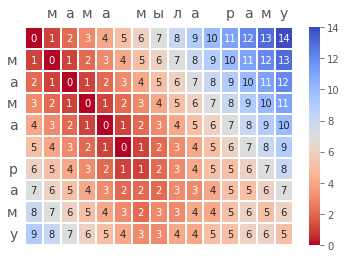

In [16]:
edit_distance('мама мыла раму', 'мама раму', plot=True)

* Подходит ли само по себе расстояние Левенштейна в качестве метрики? Почему?
* __Это абсолютная метрика. Требуется введение отношения правильно распознанных к общему количеству__

In [17]:
def error_rate(refs: Iterable[Iterable], hyps: Iterable[Iterable]) -> float:
    """
    ignoring hypotheses with empty references
    """
    
    wrong_words, all_words = 0, 0
    
    for ref, hyp in tqdm(zip(refs, hyps), total=len(refs)):
        if len(ref) > 0:
            wrong_words += edit_distance(ref, hyp)
            all_words += len(ref)
        else:
            continue
    return wrong_words / all_words


def wer(refs: Iterable[str], hyps: Iterable[str]) -> float:
    """
    Word Error Rate
    """
    return error_rate(
        [ref.split() for ref in refs],
        [hyp.split() for hyp in hyps]
    )


def cer(refs: Iterable[str], hyps: Iterable[str]) -> float:
    """
    Character Error Rate
    """
    return error_rate(refs, hyps)

* Может ли Error Rate быть > 1 ?
* __Может, если референсных слов меньше вводимых__

  
* Что дольше считать WER или CER ?
* __CER считается дольше__

In [18]:
method2wer = {model: wer(val_df[model], val_df['text']) for model in MODEL_LIST}

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

# Alignment

In [19]:
def align(ref: Iterable, hyp: Iterable) -> List[Tuple[str, str, str]]:
    
    dist = np.zeros((len(hyp) + 1, len(ref) + 1), dtype=np.int32)
    
    dist[:, 0] = np.arange(len(hyp) + 1)
    dist[0, :] = np.arange(len(ref) + 1)
    
    cache = [[None] * (len(ref) + 1) for _ in range(len(hyp) + 1)]
    
    for i, h in enumerate(hyp, start=1):
        cache[i][0] = ('I', '%', h)
    
    for i, r in enumerate(ref, start=1):
        cache[0][i] = ('D', r, '#')
        
    for i, h in enumerate(hyp, start=1):
        for j, r in enumerate(ref, start=1):
        
            cases = []
            
            if r == h:
                cases.append((
                    dist[i - 1, j - 1],
                    ('C', r, h)
                ))
            else:
                cases.append((
                    dist[i - 1, j - 1] + 1,
                    ('S', r, h)
                ))
            cases.append((
                dist[i, j - 1] + 1,
                ('D', r, '#')
            ))
            cases.append((
                dist[i - 1, j] + 1,
                ('I', '%', h)
            ))
            
            dist[i, j], cache[i][j] = min(cases, key=lambda x: x[0])
            
    alignment = []
    i, j = len(hyp), len(ref)
    
    while i != 0 or j != 0:
        action, r, h = cache[i][j]
        alignment.append((action, r, h))
        if action in {'C', 'S'}:
            i -= 1
            j -= 1
        elif action == 'I':
            i -= 1
        else:
            j -= 1

    return alignment[::-1]

In [20]:
align('мышиное обозначение', 'машинное обучение')

[('C', 'м', 'м'),
 ('S', 'ы', 'а'),
 ('C', 'ш', 'ш'),
 ('C', 'и', 'и'),
 ('I', '%', 'н'),
 ('C', 'н', 'н'),
 ('C', 'о', 'о'),
 ('C', 'е', 'е'),
 ('C', ' ', ' '),
 ('C', 'о', 'о'),
 ('C', 'б', 'б'),
 ('D', 'о', '#'),
 ('D', 'з', '#'),
 ('D', 'н', '#'),
 ('S', 'а', 'у'),
 ('C', 'ч', 'ч'),
 ('C', 'е', 'е'),
 ('C', 'н', 'н'),
 ('C', 'и', 'и'),
 ('C', 'е', 'е')]

In [21]:
align('мама мыла раму с мылом'.split(), 'мама мыла с млом'.split())

[('C', 'мама', 'мама'),
 ('C', 'мыла', 'мыла'),
 ('D', 'раму', '#'),
 ('C', 'с', 'с'),
 ('S', 'мылом', 'млом')]

# Aggregation

In [22]:
from crowdkit.aggregation import ROVER

**R**ecognizer **O**utput **V**oting **E**rror **R**eduction

https://ieeexplore.ieee.org/document/659110

https://arxiv.org/pdf/2107.01091.pdf

In [23]:
val_df.head()

,task,text,qnet,w2v,w2v_tts
1,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый
6,1254c97d2434297a886e4dc4b2a16863,илюши власова,илюши влассво,и люши власово,и люше власова
7,867e45b9a914fffff0c8ef976ee0a275,терехину,тере гину,терехину,терьехину
19,32d052f80c431869e7c13914b88f958e,айдарчике,а и дарчики,аидарчике,а и дарчике
21,719cbc316c0f3caa6324c110ad899b81,ксении валерьевны волковой,сени и воверивны в волколы,к сени и валеревны волковой,ксение ивалиревной волковой


In [24]:
def get_rover_df(df: pd.DataFrame, model_cols: List[str], tmp_col: str="__tmp") -> pd.DataFrame:

    rover_df = df.copy()
    
    if "text" in rover_df.columns:
        rover_df.drop("text", axis=1, inplace=True)
    
    rover_df[tmp_col] = rover_df.apply(lambda row: [(model, row[model]) for model in model_cols], axis=1)
    
    rover_df = rover_df.drop(model_cols, axis=1).explode(tmp_col)

    return pd.DataFrame({
        "task": rover_df["task"],
        "performer": rover_df[tmp_col].apply(lambda x: x[0]),
        "text": rover_df[tmp_col].apply(lambda x: x[1])
    })

In [25]:
val_rover_df = get_rover_df(val_df, model_cols=MODEL_LIST)

In [26]:
val_rover_df.head()

,task,performer,text
1,3c2875271fb918da312865549d444653,qnet,онпанине то тариновый
1,3c2875271fb918da312865549d444653,w2v,антонине татариновый
1,3c2875271fb918da312865549d444653,w2v_tts,антонини татариновый
6,1254c97d2434297a886e4dc4b2a16863,qnet,илюши влассво
6,1254c97d2434297a886e4dc4b2a16863,w2v,и люши власово


In [27]:
rover_result = (
    ROVER(
        tokenizer=lambda x: list(x),
        detokenizer=lambda s: "".join(s),
        silent=False
    )
    .fit_predict(val_rover_df)
)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [28]:
rover_result = pd.merge(
    val_df,
    rover_result.reset_index(),
    on='task'
)

In [29]:
rover_result.head()

,task,text,qnet,w2v,w2v_tts,agg_text
0,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый,антонине татариновый
1,1254c97d2434297a886e4dc4b2a16863,илюши власова,илюши влассво,и люши власово,и люше власова,и люши власово
2,867e45b9a914fffff0c8ef976ee0a275,терехину,тере гину,терехину,терьехину,терехину
3,32d052f80c431869e7c13914b88f958e,айдарчике,а и дарчики,аидарчике,а и дарчике,а и дарчике
4,719cbc316c0f3caa6324c110ad899b81,ксении валерьевны волковой,сени и воверивны в волколы,к сени и валеревны волковой,ксение ивалиревной волковой,ксени и валеревный волковой


In [30]:
method2wer['ROVER'] = wer(rover_result['agg_text'], rover_result['text'])

  0%|          | 0/12354 [00:00<?, ?it/s]

In [31]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613}

Попробуем модернизировать наш Rover, используя BPE, unigram, char токенизаторы из библиотеки sentencepiece.
Ссылка - [здесь](https://github.com/google/sentencepiece).
Вначале обучим наш токенизатор, к примеру, на Войне и Мире.
Исходный текст идет с пропущенными строчками, уберем их, запишем в новый файл.

In [85]:
with open('War&Peace.txt', 'r', encoding="latin-1") as inf, open('War&Peace_cleaned.txt', 'w', encoding="latin-1") as out:
    for line in inf:
        if line.strip():
            out.write(line)

In [86]:
import sentencepiece as spm
spm.SentencePieceTrainer.train('--input=War&Peace_cleaned.txt --model_prefix=m_bpe --vocab_size=2000 --model_type=bpe')
sp_model = spm.SentencePieceProcessor()
sp_model.load('m_bpe.model')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=War&Peace_cleaned.txt --model_prefix=m_bpe --vocab_size=2000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: War&Peace_cleaned.txt
  input_format: 
  model_prefix: m_bpe
  model_type: BPE
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piec

True

In [88]:
sp_model.encode_as_pieces('Съешь еще,дорогой,этих мягких французских булок и выпей чаю!')

['▁',
 'Съешь',
 '▁',
 'еще',
 ',',
 'дорогой',
 ',',
 'этих',
 '▁',
 'мягких',
 '▁',
 'французских',
 '▁',
 'булок',
 '▁',
 'и',
 '▁',
 'выпей',
 '▁',
 'чаю',
 '!']

In [89]:
rover_result = (
    ROVER(
        tokenizer=lambda x: sp_model.encode_as_pieces(x),
        detokenizer=lambda s: "".join(s).replace('▁', ' '),
        silent=False
    )
    .fit_predict(val_rover_df)
)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [90]:
rover_result = pd.merge(
    val_df,
    rover_result.reset_index(),
    on='task'
)

In [91]:
method2wer['ROVER_BPE'] = wer(rover_result['agg_text'], rover_result['text'])

  0%|          | 0/12354 [00:00<?, ?it/s]

In [92]:
# Итоговое качество
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613,
 'ROVER_BPE': 0.5818754608217709,
 'ROVER_CHAR': 0.5819034852546917,
 'ROVER_UNIGRAM': 0.5819034852546917,
 'w2v_corrected': 0.5408682049276496,
 'dummy_rescoring': 0.5129448572545953,
 'rescoring_opt': 0.5064137661321861,
 'oracle_wer': 0.49483770043019165}

Забавно, ну хуже, чем с наивным токенизатором

In [95]:
# Используем другой тип токенизатора
spm.SentencePieceTrainer.train('--input=War&Peace_cleaned.txt --model_prefix=m_char --model_type=char --vocab_size=400')
sp_char = spm.SentencePieceProcessor()
sp_char.load('m_char.model')

True

In [96]:
# Проверим разбиение
sp_model.encode_as_pieces('Съешь еще,дорогой,этих мягких французских булок и выпей чаю!')

['▁',
 'Съешь',
 '▁',
 'еще',
 ',',
 'дорогой',
 ',',
 'этих',
 '▁',
 'мягких',
 '▁',
 'французских',
 '▁',
 'булок',
 '▁',
 'и',
 '▁',
 'выпей',
 '▁',
 'чаю',
 '!']

In [97]:
rover_result = (
    ROVER(
        tokenizer=lambda x: sp_char.encode_as_pieces(x),
        detokenizer=lambda s: "".join(s).replace('▁', ' '),
        silent=False
    )
    .fit_predict(val_rover_df)
)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [98]:
rover_result = pd.merge(
    val_df,
    rover_result.reset_index(),
    on='task'
)

In [99]:
method2wer['ROVER_CHAR'] = wer(rover_result['agg_text'], rover_result['text'])

  0%|          | 0/12354 [00:00<?, ?it/s]

In [100]:
# А также униграммный токенизатор
spm.SentencePieceTrainer.train('--input=War&Peace_cleaned.txt --model_prefix=m_unigram --vocab_size=3000 --model_type=unigram')
sp_unigram = spm.SentencePieceProcessor()
sp_unigram.load('m_unigram.model')

True

In [101]:
rover_result = (
    ROVER(
        tokenizer=lambda x: sp_unigram.encode_as_pieces(x),
        detokenizer=lambda s: "".join(s).replace('▁', ' '),
        silent=False
    )
    .fit_predict(val_rover_df)
)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [102]:
rover_result = pd.merge(
    val_df,
    rover_result.reset_index(),
    on='task'
)

In [103]:
rover_result.head()

,task,text,qnet,w2v,w2v_tts,agg_text
0,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый,антонини татариновый
1,1254c97d2434297a886e4dc4b2a16863,илюши власова,илюши влассво,и люши власово,и люше власова,и илюши влассво
2,867e45b9a914fffff0c8ef976ee0a275,терехину,тере гину,терехину,терьехину,терьехину
3,32d052f80c431869e7c13914b88f958e,айдарчике,а и дарчики,аидарчике,а и дарчике,а и аидарчике
4,719cbc316c0f3caa6324c110ad899b81,ксении валерьевны волковой,сени и воверивны в волколы,к сени и валеревны волковой,ксение ивалиревной волковой,сени сени воверивны ивалиревной волковой


In [104]:
method2wer['ROVER_UNIGRAM'] = wer(rover_result['agg_text'], rover_result['text'])

  0%|          | 0/12354 [00:00<?, ?it/s]

In [105]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613,
 'ROVER_BPE': 0.5818754608217709,
 'ROVER_CHAR': 0.5819034852546917,
 'ROVER_UNIGRAM': 0.5819034852546917,
 'w2v_corrected': 0.5408682049276496,
 'dummy_rescoring': 0.5129448572545953,
 'rescoring_opt': 0.5064137661321861,
 'oracle_wer': 0.49483770043019165}

Качество ухудшилось, по всей видимости, не донца понял работу этих токенизаторов  
Будем считать попытку неудачной

* Как можно улучшить ROVER ?

# Error Correction

https://norvig.com/spell-correct.html

In [51]:
def one_edit_words(word: str) -> Set[str]:
    """
    return list of candidates with one correction
    """
    letters = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletions = [left + right[1:] for left, right in splits if right]
    substitutions = [left + c + right[1:] for left, right in splits if right for c in letters]
    insertions = [left + c + right for left, right in splits for c in letters]
    return set(deletions + substitutions + insertions)


word_counts = Counter([word for utterance in train_df['text'].str.split() for word in utterance])


@lru_cache(maxsize=None)
def correct_word(word: str) -> str:
    if word in word_counts:
        return word
    
    candidates = one_edit_words(word)
    
    candidates = sorted([
            (word, word_counts[word])
            for word in candidates if word_counts[word] > 0
        ],
        key=lambda x: -x[1]
    )
    
    if candidates:
        return max(candidates, key=lambda x: x[1])[0]
    return word

In [52]:
w2v_corrected = val_df['w2v'].apply(
    lambda x: " ".join([correct_word(w) for w in x.split()])
)

method2wer['w2v_corrected'] = wer(val_df['text'], w2v_corrected)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [106]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613,
 'ROVER_BPE': 0.5818754608217709,
 'ROVER_CHAR': 0.5819034852546917,
 'ROVER_UNIGRAM': 0.5819034852546917,
 'w2v_corrected': 0.5408682049276496,
 'dummy_rescoring': 0.5129448572545953,
 'rescoring_opt': 0.5064137661321861,
 'oracle_wer': 0.49483770043019165}

# Rescoring

In [54]:
class LaplaceLanguageModel:
    
    def __init__(
            self, 
            tokenized_texts: Iterable[Iterable[str]], 
            n: int, 
            delta: float = 0.0, 
            BOS: str='<BOS>',
            EOS: str='<EOS>'
        ):
        self.n = n
        self.BOS = BOS
        self.EOS = EOS
        ngram_counts: Dict[Tuple[str, ...], Dict[str, int]] = self.build_ngram_counts(
            tokenized_texts, n, BOS, EOS
        )
        
        self.vocab = {
            token for distribution in ngram_counts.values() for token in distribution
        }
        
        self.probs = defaultdict(Counter)

        for prefix, distribution in ngram_counts.items():
            norm: float = sum(distribution.values()) + delta * len(self.vocab)
            self.probs[prefix] = {
                token: (count + delta) / norm for token, count in distribution.items()
            }
            
    @staticmethod
    def build_ngram_counts(
        tokenized_texts: Iterable[Iterable[str]], 
        n: int,
        BOS: str,
        EOS: str
    ) -> Dict[Tuple[str, ...], Dict[str, int]]:
        
        counts = defaultdict(Counter)

        for text in tokenized_texts:

            ngrams = nltk.ngrams(
                text, n=n, pad_left=True, pad_right=True, left_pad_symbol=BOS, right_pad_symbol=EOS
            )

            for ngram in ngrams:
                prev, token = ngram[:-1], ngram[-1]
                counts[prev][token] += 1

        return counts
    
    
    def __get_observed_token_distribution(self, prefix: List[str]) -> Dict[str, float]:
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [self.BOS] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    
    def get_token_distribution(self, prefix: List[str]) -> Dict[str, float]:
        
        distribution: Dict[str, float] = self.__get_observed_token_distribution(prefix)
        
        missing_prob_total: float = 1.0 - sum(distribution.values())
        
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(distribution))
        
        return {token: distribution.get(token, missing_prob) for token in self.vocab}
    
    
    def get_next_token_prob(self, prefix: List[str], next_token: str):
        
        distribution: Dict[str, float] = self.__get_observed_token_distribution(prefix)
        
        if next_token in distribution:
            return distribution[next_token]
        
        else:
            missing_prob_total = 1.0 - sum(distribution.values())
            return max(0, missing_prob_total) / max(1, len(self.vocab) - len(distribution))
    
    
    def score_sequence(self, tokens: List[str], min_logprob: float = np.log(10 ** -50.)) -> float:
        prefix = [self.BOS] * (self.n - 1)
        padded_tokens = tokens + [self.EOS]
        logprobs_sum = 0.0
        for token in padded_tokens:
            logprob = np.log(self.get_next_token_prob(prefix, token))
            prefix = prefix[1:] + [token]
            logprobs_sum += max(logprob, min_logprob)
        return logprobs_sum / len(tokens) if tokens else 0.0

In [122]:
lm = LaplaceLanguageModel(
    n=5,
    tokenized_texts=text_data[0],
    delta=1e-5
)

In [123]:
for text in ('мама мыла раму', 'мамо мыла раму', 'машинное обучение', 'маинное обучение'):
    score = lm.score_sequence(list(text))
    print(f"{text}\t\t{score:.2f}")

мама мыла раму		-2.50
мамо мыла раму		-3.82
машинное обучение		-1.86
маинное обучение		-2.52


In [124]:
max_likelihood_utterances = val_df.apply(
    lambda row: row[
        np.array([
            lm.score_sequence(tokens=list(row[model])) for model in MODEL_LIST
        ]).argmax()
    ], 
    axis=1
)

In [125]:
method2wer['dummy_rescoring'] = wer(val_df['text'], max_likelihood_utterances)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [127]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613,
 'ROVER_BPE': 0.5818754608217709,
 'ROVER_CHAR': 0.5819034852546917,
 'ROVER_UNIGRAM': 0.5819034852546917,
 'w2v_corrected': 0.5408682049276496,
 'dummy_rescoring': 0.5129448572545953,
 'rescoring_opt': 0.5064137661321861,
 'oracle_wer': 0.49483770043019165}

Попробуем перебрать по "сетке" параметры delta и n для сглаживания.
Перебирается долго, ограничим n в пределах 7, а delta в 1e-2

In [60]:
wers = []
for n in range(1,7):
    for delta in np.linspace(start=1e-6, stop=1e-2, num=10):
        lm = LaplaceLanguageModel(n=n, tokenized_texts=text_data[0], delta=delta)
        max_likelihood_utterances = val_df.apply(
        lambda row: row[
            np.array([
                lm.score_sequence(tokens=list(row[model])) for model in MODEL_LIST
            ]).argmax()
        ], axis=1)
        wer_score = wer(val_df['text'], max_likelihood_utterances)
        print(f"Iter n={n} with delta={delta} | Wer = {wer_score}")
        wers.append(wer_score)
print(sorted(wers))

  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=1e-06 | Wer = 0.6491982792334767


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.001112 | Wer = 0.6572545952287837


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.002223 | Wer = 0.6491200625733281


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.003334 | Wer = 0.6490809542432538


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.004445 | Wer = 0.6490418459131795


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.005556 | Wer = 0.6491200625733281


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.006667 | Wer = 0.6490809542432538


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.007778 | Wer = 0.6491591709034025


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.008889 | Wer = 0.6491591709034025


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=1 with delta=0.01 | Wer = 0.6492764958936253


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=1e-06 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.001112 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.002223 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.003334 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.004445 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.005556 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.006667 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.007778 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.008889 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=2 with delta=0.01 | Wer = 0.6509581540868205


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=1e-06 | Wer = 0.6163472819710598


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.001112 | Wer = 0.6154477903793508


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.002223 | Wer = 0.615213140398905


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.003334 | Wer = 0.6148611654282362


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.004445 | Wer = 0.6149784904184591


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.005556 | Wer = 0.6145874071177161


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.006667 | Wer = 0.6139616738365272


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.007778 | Wer = 0.6140007821666015


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.008889 | Wer = 0.6140007821666015


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=3 with delta=0.01 | Wer = 0.6139616738365272


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=1e-06 | Wer = 0.5493938208838482


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.001112 | Wer = 0.5450919045756746


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.002223 | Wer = 0.5452092295658976


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.003334 | Wer = 0.5442706296441142


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.004445 | Wer = 0.5434884630426281


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.005556 | Wer = 0.5432929213922566


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.006667 | Wer = 0.5421587798201016


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.007778 | Wer = 0.5417676965193586


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.008889 | Wer = 0.5414157215486899


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=4 with delta=0.01 | Wer = 0.5412592882283926


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=1e-06 | Wer = 0.5119671490027375


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.001112 | Wer = 0.50817364098553


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.002223 | Wer = 0.5077043410246382


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.003334 | Wer = 0.508564724286273


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.004445 | Wer = 0.5074696910441924


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.005556 | Wer = 0.5078998826750097


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.006667 | Wer = 0.507665232694564


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.007778 | Wer = 0.5077043410246382


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.008889 | Wer = 0.5069612827532264


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=5 with delta=0.01 | Wer = 0.5064137661321861


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=1e-06 | Wer = 0.526476339460305


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.001112 | Wer = 0.5175205318732891


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.002223 | Wer = 0.5159561986703167


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.003334 | Wer = 0.5156433320297223


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.004445 | Wer = 0.5147829487680876


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.005556 | Wer = 0.5140007821666015


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.006667 | Wer = 0.5126710989440751


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.007778 | Wer = 0.5135314822057098


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.008889 | Wer = 0.5129057489245209


  0%|          | 0/12354 [00:00<?, ?it/s]

Iter n=6 with delta=0.01 | Wer = 0.5131012905748924
[0.5064137661321861, 0.5069612827532264, 0.5074696910441924, 0.507665232694564, 0.5077043410246382, 0.5077043410246382, 0.5078998826750097, 0.50817364098553, 0.508564724286273, 0.5119671490027375, 0.5126710989440751, 0.5129057489245209, 0.5131012905748924, 0.5135314822057098, 0.5140007821666015, 0.5147829487680876, 0.5156433320297223, 0.5159561986703167, 0.5175205318732891, 0.526476339460305, 0.5412592882283926, 0.5414157215486899, 0.5417676965193586, 0.5421587798201016, 0.5432929213922566, 0.5434884630426281, 0.5442706296441142, 0.5450919045756746, 0.5452092295658976, 0.5493938208838482, 0.6139616738365272, 0.6139616738365272, 0.6140007821666015, 0.6140007821666015, 0.6145874071177161, 0.6148611654282362, 0.6149784904184591, 0.615213140398905, 0.6154477903793508, 0.6163472819710598, 0.6490418459131795, 0.6490809542432538, 0.6490809542432538, 0.6491200625733281, 0.6491200625733281, 0.6491591709034025, 0.6491591709034025, 0.64919827923

Получаем лучшее решение при n = 5 и delta = 0,01

In [128]:
lm = LaplaceLanguageModel(
    n=5,
    tokenized_texts=text_data[0],
    delta=1e-2
)

In [129]:
max_likelihood_utterances = val_df.apply(
    lambda row: row[
        np.array([
            lm.score_sequence(tokens=list(row[model])) for model in MODEL_LIST
        ]).argmax()
    ], 
    axis=1
)

In [130]:
method2wer['rescoring_opt'] = wer(val_df['text'], max_likelihood_utterances)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [131]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613,
 'ROVER_BPE': 0.5818754608217709,
 'ROVER_CHAR': 0.5819034852546917,
 'ROVER_UNIGRAM': 0.5819034852546917,
 'w2v_corrected': 0.5408682049276496,
 'dummy_rescoring': 0.5129448572545953,
 'rescoring_opt': 0.5064137661321861,
 'oracle_wer': 0.49483770043019165}

# Oracle WER

если представить, что мы идеально выбираем лучшую из трех гипотез (Оракул), каким будет Word Error Rate?\
таким образом оценим нижнюю границу Rescoring-системы

In [132]:
def get_best_transcription(ref: Iterable[str], hyps: Iterable[Iterable[str]]):
    return hyps[
        np.array([
            edit_distance(ref, hyp) for hyp in hyps
        ]).argmin()
    ]

In [133]:
oracle_hyp = val_df.apply(
    lambda row: " ".join(
        get_best_transcription(
            ref=row['text'].split(),
            hyps=[row[model].split() for model in MODEL_LIST]
        )
    ),
    axis=1
)

In [134]:
method2wer['oracle_wer'] = wer(val_df['text'], oracle_hyp)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [135]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'ROVER': 0.5634646316005613,
 'ROVER_BPE': 0.5818754608217709,
 'ROVER_CHAR': 0.5819034852546917,
 'ROVER_UNIGRAM': 0.5819034852546917,
 'w2v_corrected': 0.5408682049276496,
 'dummy_rescoring': 0.5129448572545953,
 'rescoring_opt': 0.5064137661321861,
 'oracle_wer': 0.49483770043019165}

Как вывод - с учетом "оптимизации" параметров мы не добились нижней оценки рескоринга при помощи оракула

# Prediction

In [136]:
max_likelihood_utterances = test_df.apply(
    lambda row: row[
        np.array([
            lm.score_sequence(tokens=list(row[model])) for model in MODEL_LIST
        ]).argmax()
    ], 
    axis=1
)

In [141]:
rescoring_result = pd.DataFrame(max_likelihood_utterances)

In [148]:
rescoring_result['task'] = test_df['task']
rescoring_result.rename(columns = {0 : 'prediction'}, inplace = True)

In [149]:
rescoring_result

,prediction,task
0,73aff8bc8d99278c6ca6d1ac243557e3,73aff8bc8d99278c6ca6d1ac243557e3
1,вектор упавнович чунула к лещенуму,ba8443f3cc91e56667278db36dea02b7
2,риме менниковой,af346fae1d5686a357e32710c5d4f13e
3,александровик провичо,262fda7ab40a8417b99ecb314b3f7405
4,ерославцев,08bd8fb35ceaf2843734ffeb389f2283
...,...,...
18870,35e142d32571927fa08227a5d1a89152,35e142d32571927fa08227a5d1a89152
18871,дальфурму на карте,0c7beaae1712adf488fae74a4966b661
18872,городская полекленника но меродинадцать,5de895309c234ced55d31f001e930250
18873,beda99f2bada550facb9a70c1c48a62b,beda99f2bada550facb9a70c1c48a62b


In [151]:
username = "Ustsov"

test_result.to_json(
    f"noisy_text_aggregation_test_prediction_{username}.jsonl",
    lines=True, orient="records"
)

# TODO

* провести эксперименты с разными подходами
* аккуратно валидироваться и тестироваться
* сформировать файл с предсказаниями
* <font color='red'>в переменную `username` указать фамилию <font> 
* прикрепить на портале jupyter-notebook / .py-file / colab-link и файл с предсказаниями